In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../data/nifty_with_regime_5min.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

df.head()


,datetime,open,high,low,close,volume,futures_open,futures_high,futures_low,futures_close,...,spot_return,futures_return,avg_iv,iv_spread,pcr_oi,pcr_volume,ema_5,ema_15,regime_raw,regime
0,2024-01-01 09:20:00,21693.90,21701.05,21684.75,21696.55,0,21705.645921,21727.351567,21679.857477,21701.559036,...,0.000129,-0.000188,0.193708,-0.003351,3.399499,2.827195,21694.683333,21694.100000,0,1
1,2024-01-01 09:25:00,21697.30,21704.10,21693.20,21700.80,0,21701.559036,21736.052258,21679.857477,21714.337920,...,0.000196,0.000589,0.128904,-0.017785,0.986891,0.731724,21696.722222,21694.937500,1,0
2,2024-01-01 09:30:00,21700.15,21705.80,21684.05,21703.05,0,21714.337920,21747.814200,21692.623582,21726.088112,...,0.000104,0.000541,0.156905,-0.013343,0.635630,3.496468,21698.831481,21695.951562,1,0
3,2024-01-01 09:35:00,21703.05,21711.90,21689.70,21689.70,0,21726.088112,21747.814200,21671.973884,21693.667552,...,-0.000615,-0.001492,0.139405,-0.009458,1.612021,0.133382,21695.787654,21695.170117,1,0
4,2024-01-01 09:40:00,21688.00,21708.45,21685.75,21706.05,0,21693.667552,21731.730741,21671.973884,21710.020721,...,0.000754,0.000754,0.133763,-0.009058,0.411044,0.227555,21699.208436,21696.530103,1,0


In [3]:
df['signal'] = 0

# EMA crossover
df['ema_diff'] = df['ema_5'] - df['ema_15']

df.loc[
    (df['ema_diff'] > 0) &
    (df['ema_diff'].shift(1) <= 0) &
    (df['regime'] == 1),
    'signal'
] = 1   # LONG

df.loc[
    (df['ema_diff'] < 0) &
    (df['ema_diff'].shift(1) >= 0) &
    (df['regime'] == -1),
    'signal'
] = -1  # SHORT


In [4]:
position = 0
entry_price = 0

trades = []

for i in range(len(df)):
    row = df.iloc[i]

    # ENTRY
    if position == 0:
        if row['signal'] == 1:
            position = 1
            entry_price = row['close']
            entry_time = row['datetime']

        elif row['signal'] == -1:
            position = -1
            entry_price = row['close']
            entry_time = row['datetime']

    # EXIT
    elif position == 1 and row['ema_diff'] < 0:
        exit_price = row['close']
        trades.append([
            entry_time, row['datetime'], "LONG",
            entry_price, exit_price,
            exit_price - entry_price
        ])
        position = 0

    elif position == -1 and row['ema_diff'] > 0:
        exit_price = row['close']
        trades.append([
            entry_time, row['datetime'], "SHORT",
            entry_price, exit_price,
            entry_price - exit_price
        ])
        position = 0


In [5]:
trades_df = pd.DataFrame(
    trades,
    columns=[
        'entry_time','exit_time','side',
        'entry_price','exit_price','pnl'
    ]
)

trades_df.head()


,entry_time,exit_time,side,entry_price,exit_price,pnl
0,2024-02-08 10:05:00,2024-02-08 12:45:00,SHORT,21932.40,21800.7,131.70
1,2024-02-09 09:15:00,2024-02-09 09:20:00,SHORT,21682.65,21756.6,-73.95
2,2024-02-14 09:15:00,2024-02-14 10:55:00,SHORT,21585.90,21635.1,-49.20
3,2024-02-15 10:05:00,2024-02-15 11:00:00,LONG,21862.75,21848.3,-14.45
4,2024-02-15 11:35:00,2024-02-15 11:40:00,LONG,21861.70,21858.0,-3.70


In [6]:
trades_df.to_csv("../data/trades_log.csv", index=False)


In [7]:
total_trades = len(trades_df)
total_pnl = trades_df['pnl'].sum()

win_rate = (trades_df['pnl'] > 0).mean() * 100
avg_pnl = trades_df['pnl'].mean()

returns = trades_df['pnl']
sharpe = returns.mean() / returns.std() * np.sqrt(252*75)

max_drawdown = (returns.cumsum().cummax() - returns.cumsum()).max()

print("Total Trades:", total_trades)
print("Total PnL:", round(total_pnl,2))
print("Win Rate (%):", round(win_rate,2))
print("Average PnL:", round(avg_pnl,2))
print("Sharpe Ratio:", round(sharpe,2))
print("Max Drawdown:", round(max_drawdown,2))


Total Trades: 62
Total PnL: -124.15
Win Rate (%): 20.97
Average PnL: -2.0
Sharpe Ratio: -1.82
Max Drawdown: 665.15


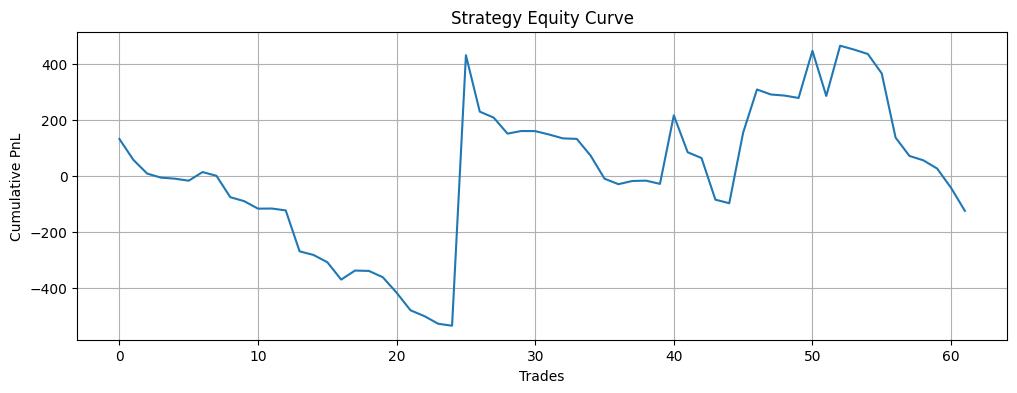

In [15]:
# import os
# os.makedirs("../plots", exist_ok=True)

# equity = trades_df['pnl'].cumsum()

# plt.figure(figsize=(12,4))
# plt.plot(equity)
# plt.title("Strategy Equity Curve")
# plt.xlabel("Trades")
# plt.ylabel("Cumulative PnL")
# plt.grid()
# plt.savefig("../plots/equity_curve.png")
# plt.show()
equity = trades_df['pnl'].cumsum()

plt.figure(figsize=(12,4))
plt.plot(equity)
plt.title("Strategy Equity Curve")
plt.xlabel("Trades")
plt.ylabel("Cumulative PnL")
plt.grid()
plt.savefig("../plots/equity_curve.png")
plt.show()
import os
os.makedirs("../results", exist_ok=True)
with open("../results/strategy_metrics.txt", "w") as f:
    f.write(f"Total Trades: {total_trades}\n")
    f.write(f"Total PnL: {total_pnl}\n")
    f.write(f"Win Rate (%): {win_rate}\n")
    f.write(f"Average PnL: {avg_pnl}\n")
    f.write(f"Sharpe Ratio: {sharpe}\n")
    f.write(f"Max Drawdown: {max_drawdown}\n")